## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Mon May 26 13:20:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 88%   64C    P0             65W /  170W |    2546MiB /  12288MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print(HOME)

c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references


## Install Grounding DINO & additional dependencies

Additional packages:
- `roboflow` - To download and send datasets to cloud.
- `dataclasses-json` - To make it easier to process COCO JSON and load data from disk.
- `onemetric` - To compare the results of manual labeling with those obtained with Grounding DINO.

In [2]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git

%cd /content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
!sed -i 's/value.type()/value.scalar_type()/g' ms_deform_attn_cuda.cu
!sed -i 's/value.scalar_type().is_cuda()/value.is_cuda()/g' ms_deform_attn_cuda.cu

%cd {HOME}/GroundingDINO

# we use latest Grounding DINO model API that is not official yet
!git checkout feature/more_compact_inference_api

!pip install -q -e .
!pip install -q roboflow dataclasses-json onemetric

c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references


c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


[WinError 3] The system cannot find the path specified: '/content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn'
c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references


Cloning into 'GroundingDINO'...
c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\.venv\lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
'sed' is not recognized as an internal or external command,
operable program or batch file.


c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\GroundingDINO


'sed' is not recognized as an internal or external command,
operable program or batch file.


branch 'feature/more_compact_inference_api' set up to track 'origin/feature/more_compact_inference_api'.


Switched to a new branch 'feature/more_compact_inference_api'
  DEPRECATION: Legacy editable install of groundingdino==0.1.0 from file:///C:/Users/SABIO/Documents/GitHub/Pool-Detection-CNN/references/GroundingDINO (setup.py develop) is deprecated. pip 25.3 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457


**NOTE:** Before we begin, let's still log the version of all the key libraries we will use.

In [4]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
roboflow: 1.1.64 ; supervision: 0.4.0


**NOTE:** To run the Grounding DINO model we will need two things: a configuration file and a weights file. The first one is part of the repository we just cloned. The second one we need to download.

In [5]:
# confirm that configuration file exist

import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [6]:
# download weights file

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
mkdir: cannot create directory ‘/content/weights’: File exists
/content/weights


In [7]:
# confirm that weights file exist

import os

WEIGHTS_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


## Load model

In [9]:
!rm -f ~/.huggingface/token

from huggingface_hub import login
login("GRID_DINO_API_KEY") # Replace this

In [10]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

/content/GroundingDINO


Importing from timm.models.layers is deprecated, please import via timm.layers
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Model Prompt Engineering Testing

In [18]:
SOURCE_IMAGE_PATH = f"{HOME}/images/89.PNG"
CLASSES = ['pool']
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

### Caption Inference

c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\.venv\lib\site-packages\transformers\modeling_utils.py:1613: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\.venv\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\.venv\lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
c:\users\sabio\documents\github\pool-detection-cnn\groundingdino\gr

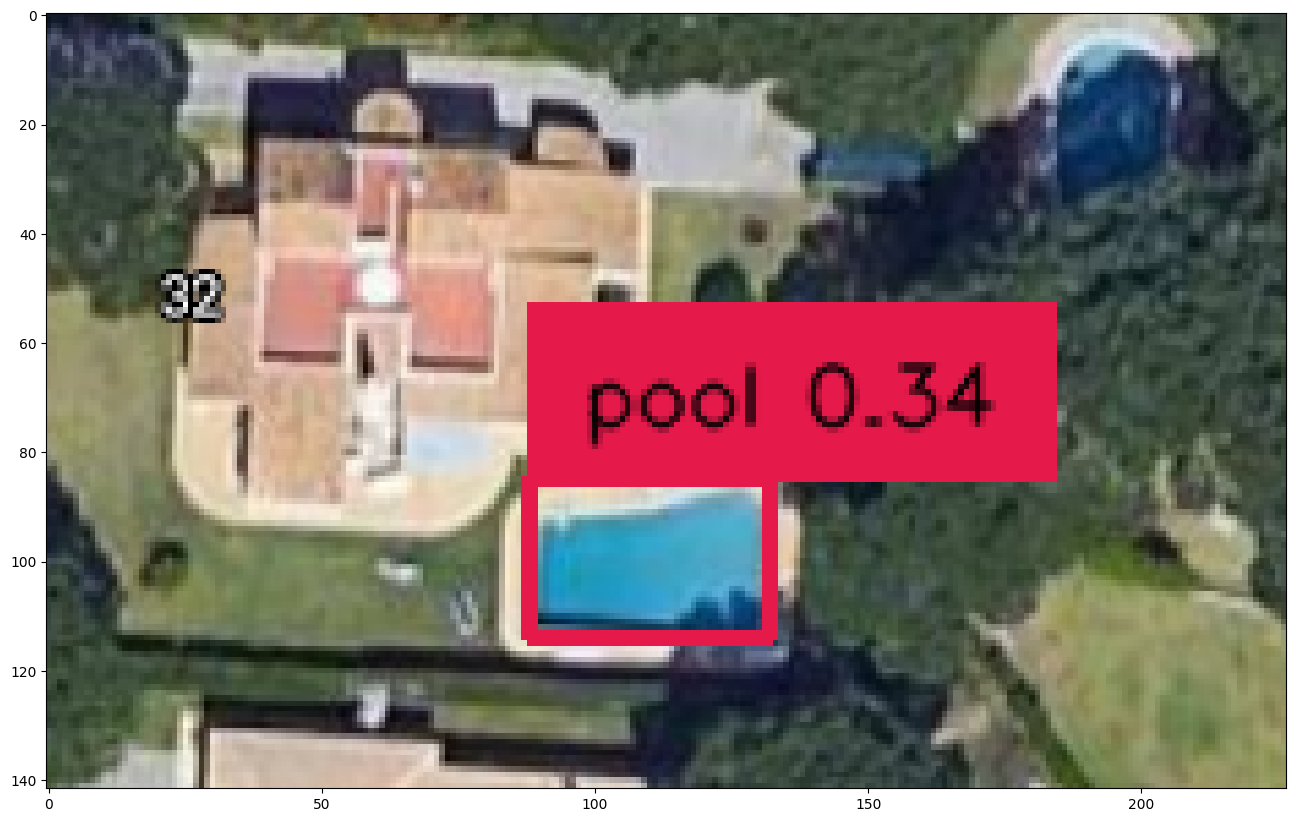

In [6]:
import cv2
import supervision as sv
import os

# Load image
image = cv2.imread(SOURCE_IMAGE_PATH)
caption = ", ".join(CLASSES)

# Run inference
detections, labels = model.predict_with_caption(
    image=image,
    caption=caption,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# Annotate results
box_annotator = sv.BoxAnnotator()
labels = [
    f"{label} {confidence:0.2f}"
    for label, (_, confidence, class_id, _)
    in zip(labels, detections)
]
annotated_frame = box_annotator.annotate(
    scene=image.copy(),
    detections=detections,
    labels=labels
)

# Display annotated image
sv.plot_image(annotated_frame, (16, 16))


### Classes Inference Mode

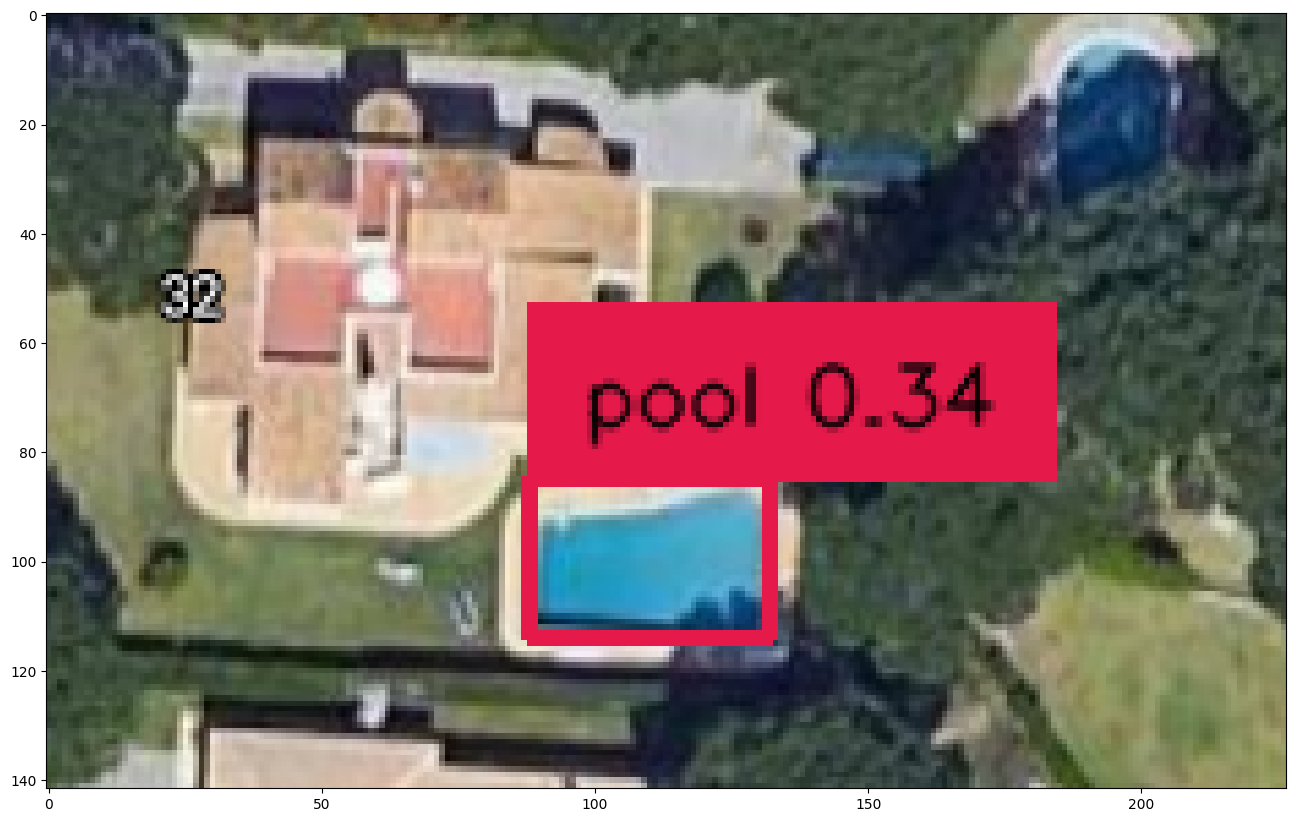

In [7]:
import cv2

import supervision as sv


image = cv2.imread(SOURCE_IMAGE_PATH)

detections = model.predict_with_classes(
    image=image,
    classes=CLASSES,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

### Enhanced Classes Inference Mode

In [8]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

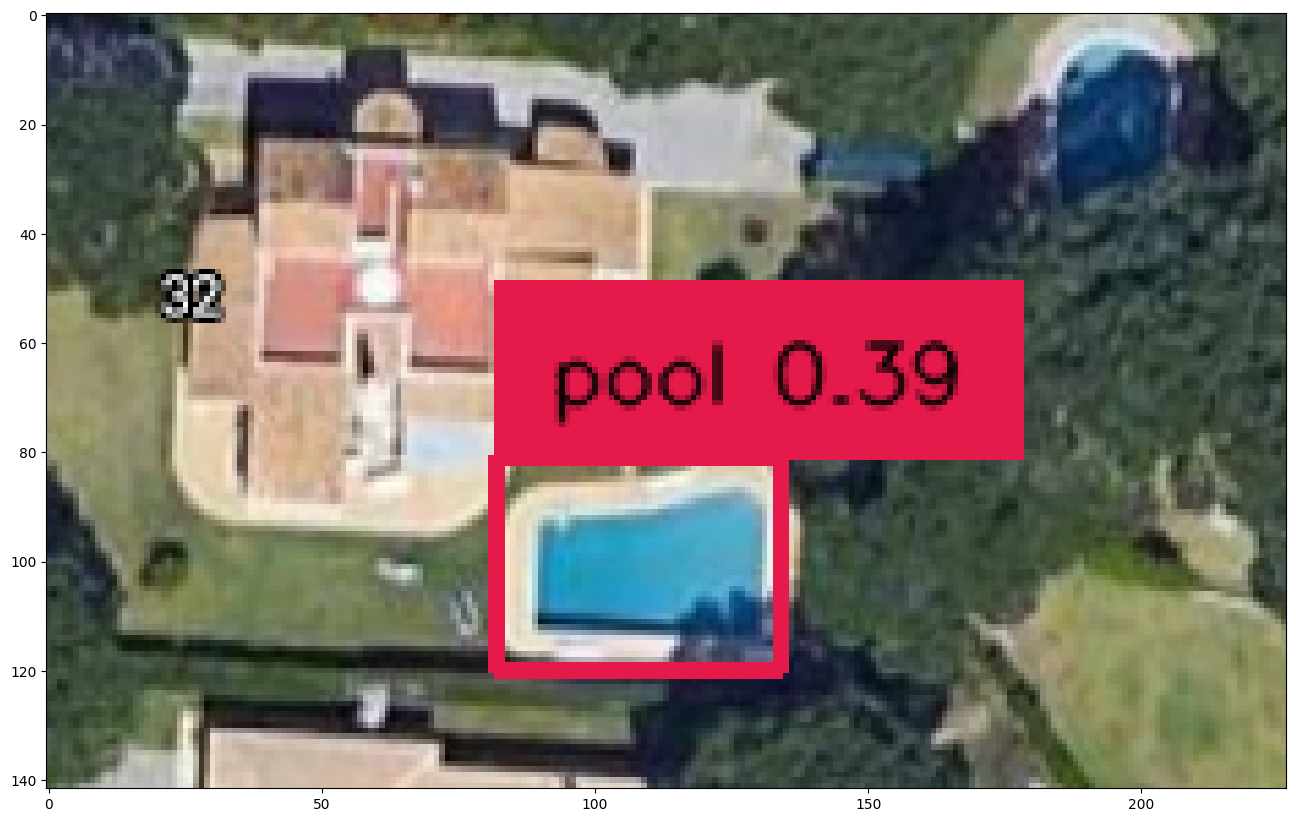

In [9]:
import cv2

import supervision as sv


image = cv2.imread(SOURCE_IMAGE_PATH)

detections = model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## Dataset auto annotation

### Define Functions

In [15]:
import os


def list_image_files(directory: str) -> List[str]:
    image_extensions = [".jpeg", ".jpg", ".png", ".bmp", ".gif"]
    image_files = [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]
    return image_files


def save_voc_xml(xml_string: str, file_path: str) -> None:
    with open(file_path, 'w') as f:
        f.write(xml_string)


def image_name_to_xml_name(image_name: str) -> str:
    base_name, _ = os.path.splitext(image_name)
    xml_name = f"{base_name}.xml"
    return xml_name

In [19]:
import os
import random
import cv2
import numpy as np
from supervision import Detections, BoxAnnotator, plot_images_grid

# --- Utility functions (no supervision.tools needed) ---

def get_annotations_by_image_path(coco_data, image_path):
    image_id = next((img.id for img in coco_data.images if img.file_name == image_path), None)
    return [ann for ann in coco_data.annotations if ann.image_id == image_id]

def annotations2detections(annotations):
    xyxy = []
    confidences = []
    class_ids = []
    for ann in annotations:
        x, y, w, h = ann.bbox
        xyxy.append([x, y, x + w, y + h])
        confidences.append(1.0)
        class_ids.append(ann.category_id)
    return Detections(
        xyxy=np.array(xyxy, dtype=np.float32),
        confidence=np.array(confidences, dtype=np.float32),
        class_id=np.array(class_ids, dtype=int)
    )

def enhance_class_name(class_names):
    return [f"a photo of a {name}" for name in class_names]

### Create empty Roboflow project

In [6]:
import os

HOME = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN"

PROJECT_NAME = "Pool-Detect-CNN"
PROJECT_DESCRIPTION = "Detect-pools-in-satelite-images"
SOURCE_DIRECTORY_PATH = os.path.join(HOME, "images")
CLASSES = ['pool']
BOX_TRESHOLD = 0.25
TEXT_TRESHOLD = 0.25

In [7]:
from roboflow import Roboflow

workspace = Roboflow().workspace()
new_project = workspace.create_project(
    project_name=PROJECT_NAME,
    project_license="MIT",
    project_type="object-detection",
    annotation=PROJECT_DESCRIPTION)

loading Roboflow workspace...
loading Roboflow project...


### Detect and Upload Annotations to New Project

In [21]:
from os import listdir
import cv2
import supervision as sv


for image_name in list_image_files(SOURCE_DIRECTORY_PATH):
    image_path = os.path.join(SOURCE_DIRECTORY_PATH, image_name)
    image = cv2.imread(image_path)
    height, width, depth = image.shape
    xml_name = image_name_to_xml_name(image_name=image_name)
    xml_path = os.path.join(SOURCE_DIRECTORY_PATH, xml_name)

    detections = model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    # drop potential detections with phrase that is not part of CLASSES set
    detections = detections[detections.class_id != None]
    # drop potential detections with area close to area of whole image
    detections = detections[(detections.area / (height * width)) < 0.9 ]
    # drop potential double detections
    # detections = detections.with_nms()

    xml_string = sv.detections_to_voc_xml(
        detections=detections,
        classes=CLASSES,
        filename=image_name,
        width=width,
        height=height,
        depth=depth
    )

    save_voc_xml(xml_string=xml_string, file_path=xml_path)
    new_project.upload(image_path=image_path, annotation_path=xml_path, split="train", overwrite=True)

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


## Final Steps (Before Training YOLO)

Open RoboFlow and find the project that is newly created there. Go into the dataset and correct the bounding boxes for each image as well as remove any boxes that were falsely created. No need to make any extra classes as YOLO will classify a classless image as **background.**  
  
Once you have finished annotating the dataset, you can version your data. Keep all the options for the data stock, however, for the split, set it to 70/20/10 (train, validate, test).  
  
Select download dataset (code version) and have the data in there ready for the next notebook. You will need to replace some information there.